# **Preliminary actions**

In this macro-section we will perform the following tasks:
- Install and import useful packages and libraries
- Create and configure the Spark Context
- Mount Google Drive
- Import as dataframe the csv files from Google Drive


In [1]:
# Install PySpark 
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 19 kB/s 
     |████████████████████████████████| 198 kB 59.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=b74f4309c24c04e456ac0bf030643c49c25ff56ef0c777f7e279e1f98a4eaf6f
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [2]:
# Import first useful libraries
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import datetime as dt
from pyspark.sql.functions import col, max as max_
import pandas as pd


In [3]:
# Create the session
conf = SparkConf().set("spark.ui.port", "4051").set('spark.executor.memory', '4G').set('spark.driver.memory', '45G').set('spark.driver.maxResultSize', '10G')

# Create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [4]:
spark

In [5]:
sc._conf.getAll()

[('spark.driver.memory', '45G'),
 ('spark.app.startTime', '1654618562604'),
 ('spark.executor.id', 'driver'),
 ('spark.sql.warehouse.dir', 'file:/content/spark-warehouse'),
 ('spark.app.id', 'local-1654618567704'),
 ('spark.driver.maxResultSize', '10G'),
 ('spark.ui.port', '4051'),
 ('spark.app.name', 'pyspark-shell'),
 ('spark.driver.host', '9e2ad7f54b94'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.driver.port', '34893'),
 ('spark.submit.deployMode', 'client'),
 ('spark.executor.memory', '4G'),
 ('spark.ui.showConsoleProgress', 'true')]

In [6]:
GDRIVE_DIR = "/content/gdrive" # Our mount point on Google Drive
GDRIVE_HOME_DIR = GDRIVE_DIR + "/My Drive" # Our home directory
GDRIVE_DATA_DIR = GDRIVE_HOME_DIR + "/BigData/Dataset" # Our data specific directory

In [7]:
from google.colab import drive
drive.mount(GDRIVE_DIR, force_remount=True)

Mounted at /content/gdrive


In [8]:
# Load all the csv from Drive, creating the corresponding PySpark Dataframe

GDRIVE_DATASET_FILE_PLAYERS = GDRIVE_DATA_DIR+"/player.csv"
GDRIVE_DATASET_FILE_PLAYERS_ATTRIBUTES = GDRIVE_DATA_DIR +"/player_attributes.csv"
GDRIVE_DATASET_FILE_MATCHES = GDRIVE_DATA_DIR+"/match.csv"
GDRIVE_DATASET_FILE_TEAMS = GDRIVE_DATA_DIR+"/team.csv"
GDRIVE_DATASET_FILE_LEAGUES = GDRIVE_DATA_DIR+"/league.csv"


player_df = spark.read.load(GDRIVE_DATASET_FILE_PLAYERS, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")
player_attributes_df = spark.read.load(GDRIVE_DATASET_FILE_PLAYERS_ATTRIBUTES, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")
team_df = spark.read.load(GDRIVE_DATASET_FILE_TEAMS, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")
match_df = spark.read.load(GDRIVE_DATASET_FILE_MATCHES, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")
league_df = spark.read.load(GDRIVE_DATASET_FILE_LEAGUES, 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

# **EDA**

In the following sections we will perform some ideas of intensive Exploratory Data Analysis. Let's give a summary:
- Top Players analysis
- Top Teams analysis
- Top Matches analysis
- Goal per League analysis
- Home factor advantage analysis
- Leagues Predictability analysis


### **TOP PLAYERS ANALYSIS**

In this analysis task we want to obtain a list of the 10 players with the higher Overall and Potential value for every year (2008-2016). The first value of sorting is the Overall one, in case of equality between two players they will be ordered by Potential column. In conclusion we create a plot for every year that will graphically map players with their respective values.


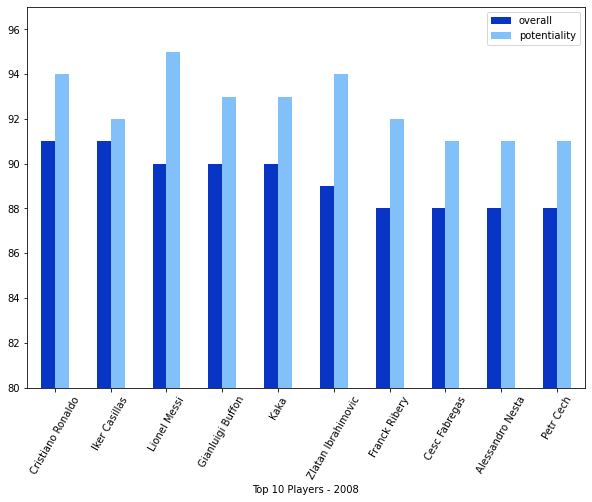

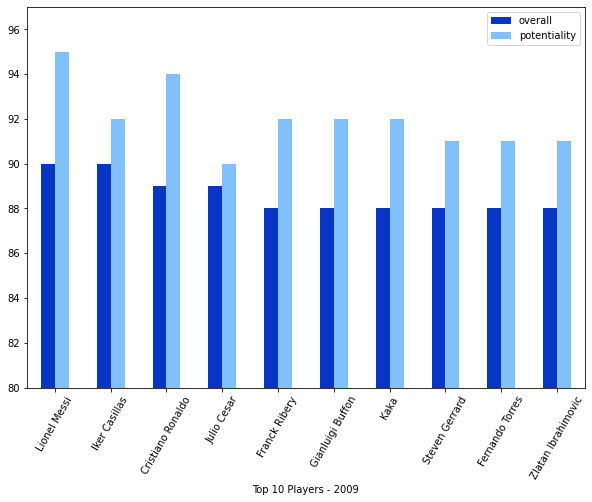

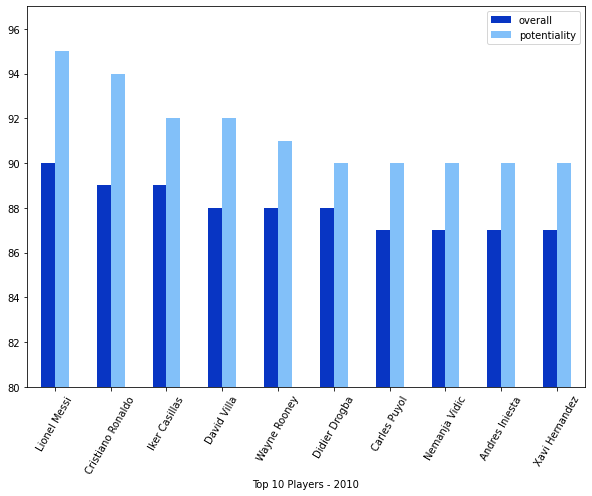

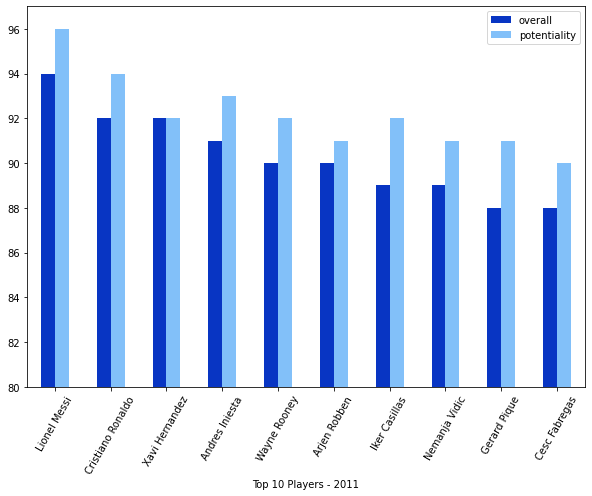

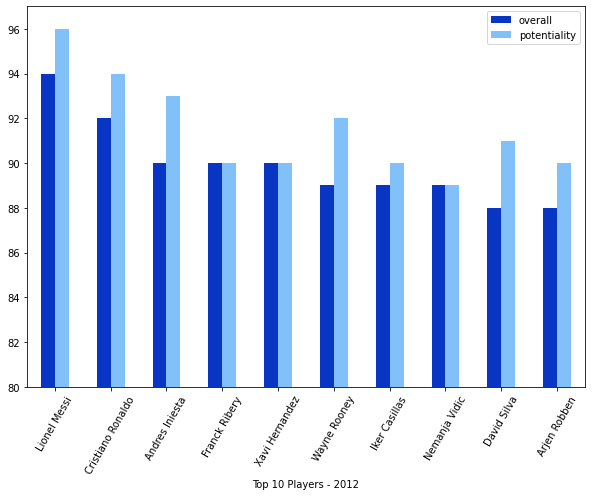

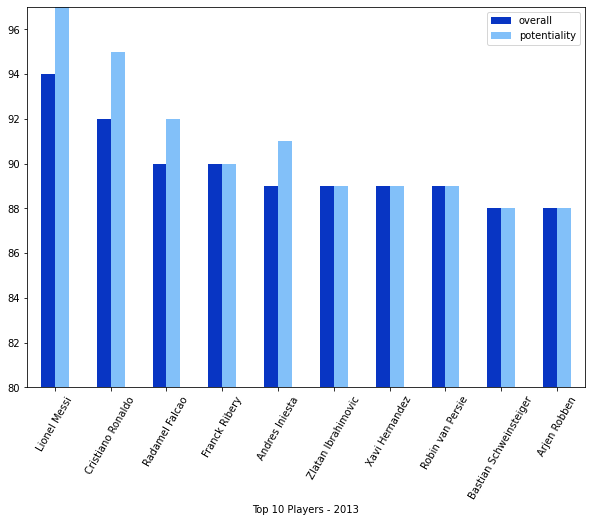

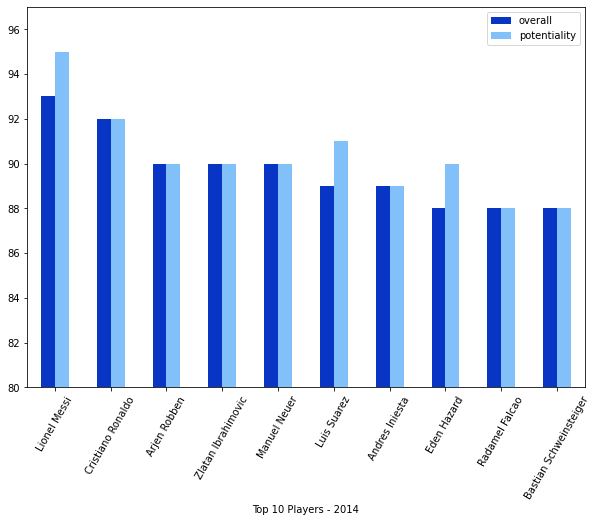

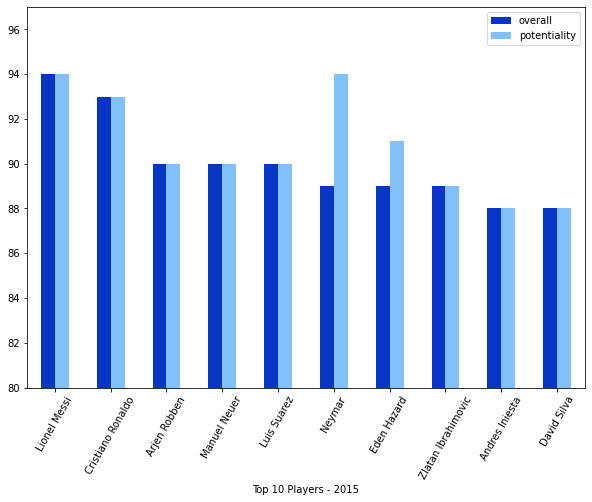

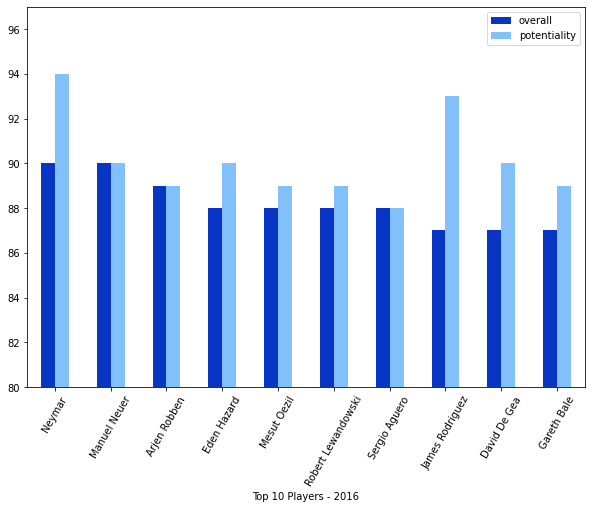

In [ ]:
### TOP PLAYERS BASED ON OVERALL AND POTENTIAL

# Iterate on the years covered by the df
for year in range(2008,2017):
  # Make some important disambiguation on Player Attributes DF's instance names (we will use it two times)
  attributes1 = player_attributes_df.alias("attributes1")
  attributes2 = player_attributes_df.alias("attributes2").withColumnRenamed("overall_rating","overall").withColumnRenamed("potential", "potentiality")
  # For the specific year take the last existing instance in terms of date (most updated) from Player Attributes DF
  players_last_instance = attributes1[attributes1['date'].contains(year)].groupBy('player_api_id').agg(max_('date'))
  # Rename date column
  players_last_instance = players_last_instance.withColumnRenamed("max(date)","date")
  # Join (on player id) with Player DF to take player name
  players_with_name = players_last_instance.join(player_df, players_last_instance.player_api_id == player_df.player_api_id) \
                      .select(players_last_instance.player_api_id, players_last_instance.date, player_df.player_name)
  # Join (on player id) with Player Attributes DF to take back overall and potential values (dropped with groupby/aggregate operation)
  players_for_year_complete = players_with_name.join(attributes2, (players_with_name.player_api_id == attributes2.player_api_id) & (players_with_name.date == attributes2.date)) \
                      .select(players_with_name.player_api_id, players_with_name.player_name, attributes2.overall, attributes2.potentiality).sort(['overall','potentiality'], ascending=False).limit(10)
  # Convert resulting DF into the corresponding Pandas DF
  pandas_plot = players_for_year_complete.toPandas()
  # Create plot bar with player names on x-axis and overall/potential values on y-axis
  pandas_plot.plot(kind = 'bar', x='player_name', y=['overall', 'potentiality'], figsize=(10,7), ylim=(80,97), color = ["#0835c3", "#82c0f9"], xlabel = "Top 10 Players - "+str(year), rot = 60)



### **TOP TEAMS ANALYSIS**
In this analysis task we want to obtain a list of the top 10 teams ever based on the number of wins in every season from 2008 to 2016.  In conclusion we create a general plot that will graphically map teams with their respective total number of wins.

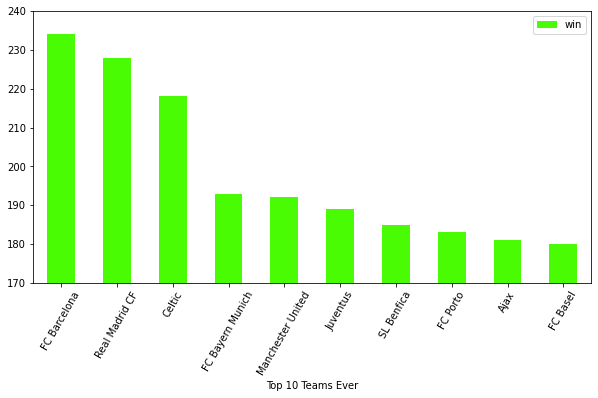

In [ ]:
### TOP TEAMS EVER BASED ON WINS

# Select only columns of our interest from matches DF
matches_df = match_df.select("id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal")
# Add new column containing id of match winner (calculated by control on difference of home and away goals) or string 'draw' 
matches_with_winner = matches_df.withColumn("winner", when(expr("home_team_goal-away_team_goal") > 0, match_df.home_team_api_id) \
                                          .otherwise(when(expr("home_team_goal-away_team_goal") < 0, match_df.away_team_api_id) \
                                          .otherwise('draw')))
# Drop rows of draws
matches_with_winner = matches_with_winner.filter(matches_with_winner.winner != "draw")
# Grouping on team with the respective number of winning instance
matches_grouped_winner = matches_with_winner.groupby('winner').count()
# Renaming columns to make table clearest
matches_grouped_winner = matches_grouped_winner.withColumnRenamed("count", "win")
matches_grouped_winner = matches_grouped_winner.withColumnRenamed("winner", "team_id")
# Join (on team ids) with Team DF to take team long name
team_analysis_complete = matches_grouped_winner.join(team_df, matches_grouped_winner.team_id == team_df.team_api_id).select(team_df.team_long_name, matches_grouped_winner.win).sort(["win"], ascending = False).limit(10)
# Convert resulting DF into the corresponding Pandas DF
pandas_plot = team_analysis_complete.toPandas()
# Create plot bar with team names on x-axis and win values on y-axis
pandas_plot.plot(kind = 'bar', x='team_long_name', y='win', figsize=(10,5), color = "#49fc03",  ylim=(170,240), xlabel = "Top 10 Teams Ever", rot = 60)



### **TOP MATCHES ANALYSIS**
In this analysis task we want to obtain a list of the top 10 matches ever based on the total number of goals between home team goals and away team goals. In this task we choose to analyze total number goals rather than sorting firstly for home goals and then for away goals. This because spectacularity of a match can be achieved better when both teams make big number of goals rather than events in which home team "destroys" away team.  In conclusion we create a general plot that will graphically map matches with their respective result in terms of home and away team goals.

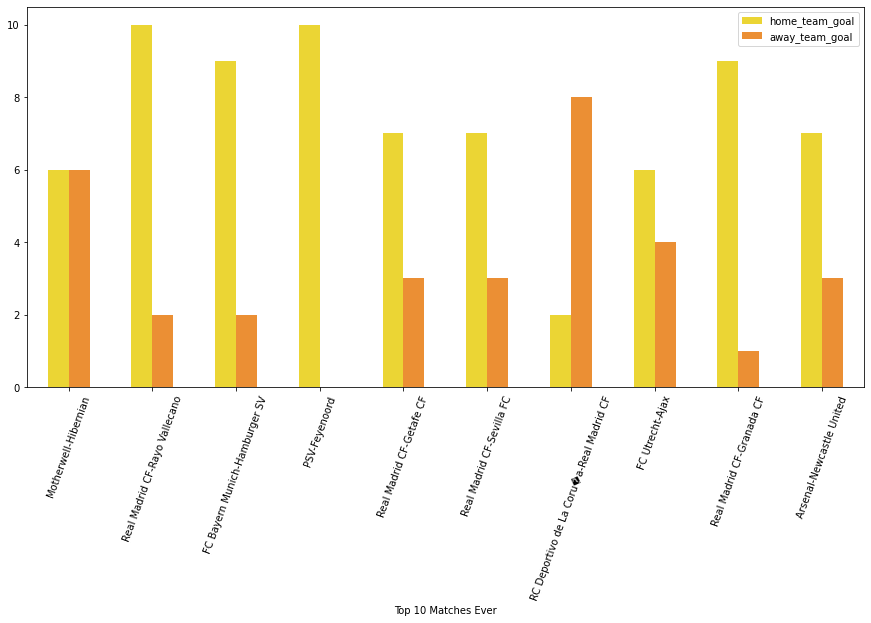

In [ ]:
### TOP MATCHES OVER SEASON BASED ON TOTAL GOALS SCORED

# Select only columns of our interest from matches DF
matches_df = match_df.select("id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal")
# Make some important disambiguation on Team DF name and on its columns (distinguishing between home and away team names)
team_home = team_df.alias("team_home").withColumnRenamed("team_long_name","team_name_home")
team_away = team_df.alias("team_away").withColumnRenamed("team_long_name","team_name_away")
# Join (on team ids) with Team Home DF to take the long name of home team  
match_in_season_home = matches_df.join(team_home, matches_df.home_team_api_id == team_home.team_api_id) \
                  .select(team_home.team_name_home, matches_df.home_team_goal, matches_df.away_team_goal, matches_df.away_team_api_id )
# Join (on team ids) the above result with Team Away DF to take the long name of away team
match_in_season_home_away = match_in_season_home.join(team_away, match_in_season_home.away_team_api_id == team_away.team_api_id) \
                  .select(match_in_season_home.team_name_home, team_away.team_name_away, match_in_season_home.home_team_goal, match_in_season_home.away_team_goal)
# Add column total_goals whose values for each row are the sum of home team goals with away team goals
match_in_season_total = match_in_season_home_away.withColumn('total_goals', expr("home_team_goal+away_team_goal"))
# Add column whose values are the string concatenation of the names of home and away team  
match_total_scores = match_in_season_total.withColumn('Match', concat_ws('-','team_name_home','team_name_away'))
# Sort resulting DF for total goals number in decreasing order, select only columns of our interest and taking first 10 rows
match_total_scores = match_total_scores.sort(["total_goals"], ascending = False).select("Match", 'home_team_goal','away_team_goal').limit(10)
# Convert resulting DF into the corresponding Pandas DF
pandas_plot = match_total_scores.toPandas()
# Create plot bar with matches names on x-axis and home/away team goals values on y-axis
pandas_plot.plot(kind = 'bar', x='Match', y=['home_team_goal', 'away_team_goal'], figsize = [15,7], color = ["#ebd534", "#eb8f34"], xlabel = "Top 10 Matches Ever", rot=70)



### **GOALS ANALYSIS OVER SEASON AMONG LEAGUES**

In this analysis task we want to obtain one list for every season containing the total number of goals of each League in order to check the trends of goals scoring in the different nations. In conclusion we create a general plot that will graphically map leagues with their respective total number of goals in the specific season.

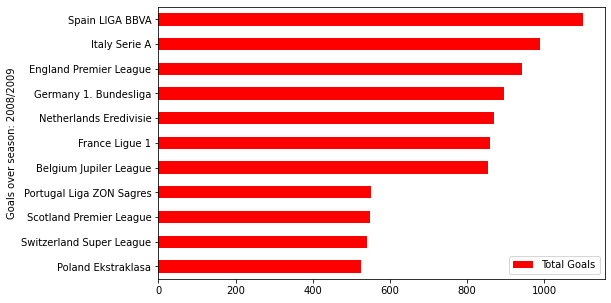

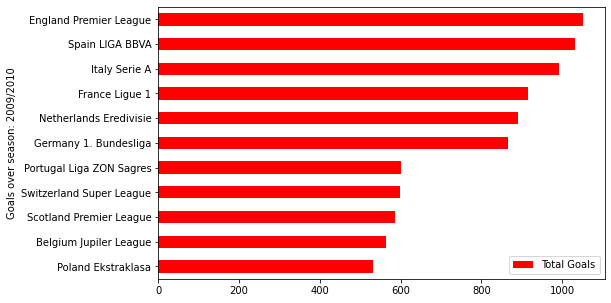

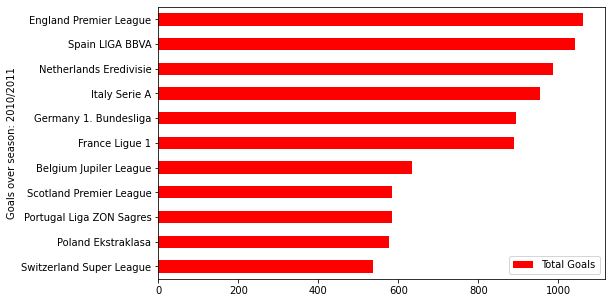

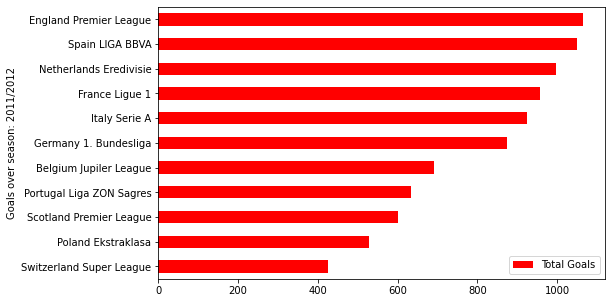

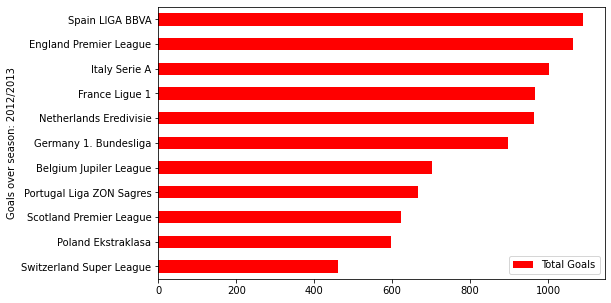

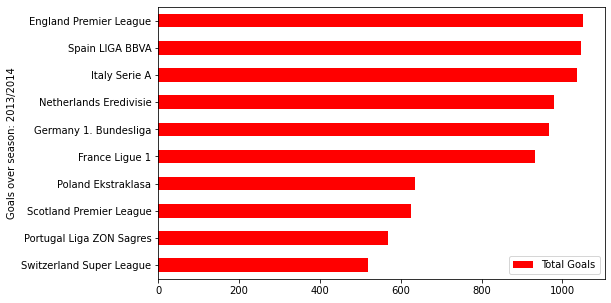

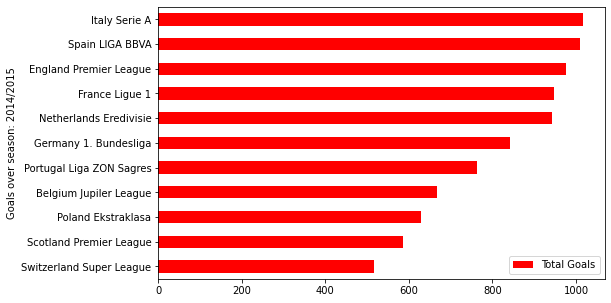

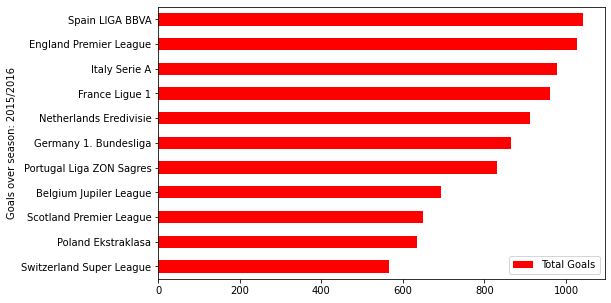

In [9]:
### GOALS ANALYSIS OVER SEASON AMONG LEAGUES

# Iterate on every season found in the matches DF
for season in match_df.select('season').distinct().dropna().sort('season', ascending = True).collect():
  # Filtering matches on specific season of the iterative cycle
  match_in_season = match_df[match_df['season'] == season.season] 
  # Grouping for league ids and mapping them with the total number of home team goals 
  goals_in_season_home = match_in_season.groupby('league_id').agg(sum('home_team_goal')).sort(['league_id'],ascending = False) 
  # Grouping for league ids and mapping them with the total number of away team goals 
  goals_in_season_away = match_in_season.groupby('league_id').agg(sum('away_team_goal')).sort(['league_id'],ascending = False) 
  # Joining (on league ids) the two above DFs
  goals_in_season_total = goals_in_season_home.join(goals_in_season_away, ["league_id"])
  # Select only the league ids and a specific column that contains the sum of total home team goals and total away team goals
  goals_in_season_total = goals_in_season_total.select('league_id', (col('sum(home_team_goal)') + col('sum(away_team_goal)')).alias("total_goals"))
  # Join (on league ids) with League DF to take league name, select only columns of our interest and sort the result for total goals in ascending order
  goals_per_league_complete = goals_in_season_total.join(league_df, league_df.id == goals_in_season_total.league_id).select(league_df.name, goals_in_season_total.total_goals).sort(["total_goals"],ascending = True) 
  # Renaming operations in order to have a clearest result
  goals_per_league_complete = goals_per_league_complete.withColumnRenamed('name', 'league')
  goals_per_league_complete = goals_per_league_complete.withColumnRenamed('total_goals', 'Total Goals')  
  if season.season == "2013/2014":
    goals_per_league_complete = goals_per_league_complete.filter(goals_per_league_complete.league != "Belgium Jupiler League")
  # Convert resulting DF into the corresponding Pandas DF
  pandas_plot = goals_per_league_complete.toPandas()
  # Create plot bar with league names on x-axis and total goals values on y-axis
  pandas_plot.plot(kind = 'barh', x='league', y='Total Goals', figsize=(8,5), color = 'r', xlabel = "Goals over season: "+season.season)

### **HOME FACTOR**
It is already well known in soccer that approximately 45% of the time the home team will win, but how does this percentage change in each championship?

In [ ]:
league_ids = league_df.select("id", "name")
xvals = []
yvals = []
zvals = []
for row in league_ids.collect(): 
  print(row.name)
  matches = match_df[match_df['league_id'] == row.id] 
  matches_scores = matches.select("id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal")
  matches_scores = matches_scores.withColumn("winner", when(expr("home_team_goal-away_team_goal") > 0, "HOME") \
                                            .otherwise(when(expr("home_team_goal-away_team_goal") < 0, "AWAY") \
                                            .otherwise('DRAW')))
  matches_scores = matches_scores.groupby('winner').count()
  outcomes = matches_scores.collect()
  away_wins = outcomes[0][1]
  home_wins = outcomes[1][1]
  draws = outcomes[2][1]
  home_win_percentage = home_wins/(draws+away_wins+home_wins)
  draws_percentage = draws/(home_wins+away_wins+draws)
  away_wins_percentage = away_wins/(draws+home_wins+away_wins)

  # we performed some prior home factor win analysis and found out that Scottish and Spanish teams
  # are at the opposite in the spectrum of home advantage importance
  if row.name == "Scotland Premier League" or row.name == "Spain LIGA BBVA":
    xvals.append(home_win_percentage)
    yvals.append(draws_percentage)
    zvals.append(away_wins_percentage)

  print("Home win: "+str((home_win_percentage*100))+" %")
  print("Draw: "+str(draws_percentage*100)+" %")
  print("Away win: "+str(away_wins_percentage*100)+" %")
  print("\n")

Belgium Jupiler League
Home win: 46.875 %
Draw: 24.59490740740741 %
Away win: 28.53009259259259 %


England Premier League
Home win: 45.723684210526315 %
Draw: 25.756578947368418 %
Away win: 28.519736842105264 %


France Ligue 1
Home win: 44.703947368421055 %
Draw: 28.25657894736842 %
Away win: 27.039473684210524 %


Germany 1. Bundesliga
Home win: 45.220588235294116 %
Draw: 24.387254901960784 %
Away win: 30.392156862745097 %


Italy Serie A
Home win: 46.635730858468676 %
Draw: 26.383824991713624 %
Away win: 26.9804441498177 %


Netherlands Eredivisie
Home win: 47.83496732026144 %
Draw: 23.733660130718953 %
Away win: 28.431372549019606 %


Poland Ekstraklasa
Home win: 45.3125 %
Draw: 27.34375 %
Away win: 27.34375 %


Portugal Liga ZON Sagres
Home win: 44.2495126705653 %
Draw: 25.97465886939571 %
Away win: 29.775828460038987 %


Scotland Premier League
Home win: 41.66666666666667 %
Draw: 24.50657894736842 %
Away win: 33.82675438596491 %


Spain LIGA BBVA
Home win: 48.848684210526315 %
D

From our home results data we can easily see that

*   Scottish championship is the one where the home advantage counts less
*   Spanish championship is the one where the home advantage counts the most





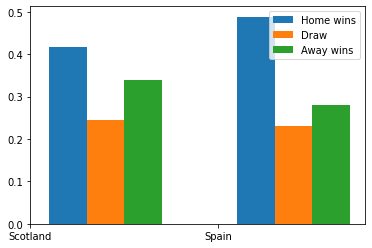

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

team = ['Scotland','Spain']

x_axis = np.arange(len(team))

# Multi bar Chart

plt.bar(x_axis +0.20, xvals, width=0.2, label = 'Home wins')
plt.bar(x_axis +0.20*2, yvals, width=0.2, label = 'Draw')
plt.bar(x_axis +0.20*3, zvals, width=0.2, label = 'Away wins')

# Xticks

plt.xticks(x_axis,team)

# Add legend

plt.legend()

# Display

plt.show()

But what about individual teams? How they perform while playing in front of their fans?

In [ ]:
team_ids = team_df.select("team_api_id", "team_long_name")
max_team = 0
max_perc = 0
max_wins = 0
max_draws = 0
max_losses = 0
wins = 0
for row in team_ids.collect(): 
  print(row.team_long_name)
  matches = match_df[match_df["home_team_api_id"] == row.team_api_id] 
  matches_scores = matches.select("id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal")
  matches_scores = matches_scores.withColumn("winner", when(expr("home_team_goal-away_team_goal") > 0, "HOME") \
                                            .otherwise(when(expr("home_team_goal-away_team_goal") < 0, "AWAY") \
                                            .otherwise('DRAW')))
  matches_scores = matches_scores.groupby('winner').count()
  outcome = matches_scores.collect()
  losses = 0
  wins = 0
  draws = 0

  for x in outcome:
    if x[0]=="AWAY":
        losses = x[1]
    if x[0]=="HOME":
        wins = x[1]
    if x[0]=="DRAW":
        draws = x[1]

  wins_perc = wins/(draws+losses+wins)
  draws_perc = draws/(wins+losses+draws)
  losses_perc = losses/(draws+wins+losses)

  if(wins_perc > max_perc):
    max_team = row.team_long_name
    max_perc = wins_perc
    max_wins = wins
    max_draws = draws
    max_losses = losses

  print("Home win: "+str((wins_perc*100))+" %")
  print("Draw: "+str((draws_perc*100))+" %")
  print("Away win: " +str((losses_perc*100))+" %")
  print("\n")

KRC Genk
Home win: 57.54716981132076 %
Draw: 23.58490566037736 %
Away win: 18.867924528301888 %


Beerschot AC
Home win: 39.473684210526315 %
Draw: 32.89473684210527 %
Away win: 27.631578947368425 %


SV Zulte-Waregem
Home win: 42.45283018867924 %
Draw: 30.18867924528302 %
Away win: 27.358490566037734 %


Sporting Lokeren
Home win: 38.67924528301887 %
Draw: 33.9622641509434 %
Away win: 27.358490566037734 %


KSV Cercle Brugge
Home win: 41.75824175824176 %
Draw: 17.582417582417584 %
Away win: 40.65934065934066 %


RSC Anderlecht
Home win: 74.52830188679245 %
Draw: 19.81132075471698 %
Away win: 5.660377358490567 %


KAA Gent
Home win: 57.798165137614674 %
Draw: 17.431192660550458 %
Away win: 24.770642201834864 %


RAEC Mons
Home win: 34.04255319148936 %
Draw: 29.78723404255319 %
Away win: 36.17021276595745 %


FCV Dender EH
Home win: 29.411764705882355 %
Draw: 23.52941176470588 %
Away win: 47.05882352941176 %


Standard de Li�ge
Home win: 62.264150943396224 %
Draw: 16.037735849056602 %
A

Out of all teams the one that has the best win percentage while playing at home is FC Barcelona

In [ ]:
#Home records of the most winning team at home
print(str(max_perc)+" % of matches played at home were wins")
print("HOME RECORDS")
print("Home wins:"+str(max_wins))
print("Home draws:"+str(max_draws))
print("Home losses:"+str(max_losses))

0.8618421052631579 % of matches played at home were wins
HOME RECORDS
Home wins:131
Home draws:12
Home losses:9


We know know that FC Barcelona it is a tough team to play against while playing at the Camp Nou. But they are performing extremely well also in away games since it is one of the best performing teams of the World.<br>
Let's try to have a better understanding investigating what team actually has the highest percentage of wins while playing in their own city.

In [ ]:
team_ids = team_df.select("team_api_id", "team_long_name")
max_team = 0
max_perc = 0
max_wins_home = 0
max_wins_away = 0

for row in team_ids.collect(): 
  print(row.team_long_name)
  matches_home = match_df[match_df["home_team_api_id"] == row.team_api_id] 
  matches_home_scores = matches_home.select("id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal")
  matches_home_scores = matches_home_scores.withColumn("winner", when(expr("home_team_goal-away_team_goal") > 0, "HOME") \
                                            .otherwise(when(expr("home_team_goal-away_team_goal") < 0, "AWAY") \
                                            .otherwise('DRAW')))
  
  matches_away = match_df[match_df["away_team_api_id"] == row.team_api_id]
  matches_away_score = matches_away.select("id", "home_team_api_id", "away_team_api_id", "home_team_goal", "away_team_goal")
  matches_away_score = matches_away_score.withColumn("winner", when(expr("home_team_goal-away_team_goal") > 0, "HOME") \
                                            .otherwise(when(expr("home_team_goal-away_team_goal") < 0, "AWAY") \
                                            .otherwise('DRAW')))


  matches_home_scores = matches_home_scores.groupby('winner').count()
  matches_away_score = matches_away_score.groupby('winner').count()
  outcome_home = matches_home_scores.collect()
  outcome_away = matches_away_score.collect()
  wins_home = 0
  wins_away = 0

  for x in outcome_home:
    if x[0]=="HOME":
        wins_home = x[1]
  
  for x in outcome_away:
    if x[0]=="AWAY":
        wins_away = x[1]

  home_wins_perc = wins_home/(wins_home+wins_away)
  print("Home wins:"+str(wins_home))
  print("Away wins:"+str(wins_away))
  print("Wins at home: "+str(home_wins_perc*100)+" %"+"\n")
  if(home_wins_perc > max_perc):
    max_team = row.team_long_name
    max_perc = home_wins_perc
    max_wins_home = wins_home
    max_wins_away = wins_away

KRC Genk
Home wins:61
Away wins:36
Wins at home: 62.88659793814433 %

Beerschot AC
Home wins:30
Away wins:10
Wins at home: 75.0 %

SV Zulte-Waregem
Home wins:45
Away wins:33
Wins at home: 57.692307692307686 %

Sporting Lokeren
Home wins:41
Away wins:33
Wins at home: 55.4054054054054 %

KSV Cercle Brugge
Home wins:38
Away wins:20
Wins at home: 65.51724137931035 %

RSC Anderlecht
Home wins:79
Away wins:57
Wins at home: 58.08823529411765 %

KAA Gent
Home wins:63
Away wins:46
Wins at home: 57.798165137614674 %

RAEC Mons
Home wins:16
Away wins:9
Wins at home: 64.0 %

FCV Dender EH
Home wins:5
Away wins:4
Wins at home: 55.55555555555556 %

Standard de Li�ge
Home wins:66
Away wins:40
Wins at home: 62.264150943396224 %

KV Mechelen
Home wins:50
Away wins:29
Wins at home: 63.29113924050633 %

Club Brugge KV
Home wins:75
Away wins:48
Wins at home: 60.97560975609756 %

KSV Roeselare
Home wins:8
Away wins:4
Wins at home: 66.66666666666666 %

KV Kortrijk
Home wins:56
Away wins:26
Wins at home: 68.

Out of all teams the one that has the higest percentage of game wins at home is CD Numancia

In [ ]:
print("The "+str(max_perc)+"% of its wins accoured while playing at home ")
print("WINS")
print("Home wins:"+str(max_wins_home))
print("Away wins:"+str(max_wins_away))

The 0.9% of its wins accoured while playing at home 
WINS
Home wins:9
Away wins:1


###**MOST PREDICTABLE LEAGUE**

It is very common to debate about the most predictible league, also while betting. There are couple of ways to explore this task:

*   One would be to compare the bet odds with the real results and look at the accuracy
*   An other one would be to look into the entropy of betting odds for each team and league

They both gave very similar results, we decided to go for the second one.



In [ ]:
from scipy.stats import entropy

def match_entropy(row):
    odds = [row.B365H,row.B365D,row.B365A]
    #change odds to probability
    probs = [1/o for o in odds]
    #normalize 
    norm = 0
    for x in probs:
      norm = norm + x
    probs = [p/norm for p in probs]
    return (row.home_team_api_id, row.away_team_api_id, row.league_id, row.season,float(entropy(probs)))
    
matches = match_df[['id', 'country_id' ,'league_id', 'season', 'stage', 'date','match_api_id', 'home_team_api_id', 'away_team_api_id','B365H', 'B365D' ,'B365A']]
matches = matches.na.drop(subset=["B365H","B365D","B365A"])
data_df = []
for row in matches.collect():
  data_df.append(match_entropy(row))
columns = ["home_team_api_id","away_team_api_id", "league_id", "season", "entropy"]
df_match_entropy = spark.createDataFrame(data=data_df, schema = columns)
df_league_entropy = df_match_entropy.groupby("league_id").avg("entropy")
df_league_entropy = df_league_entropy.join(league_df,df_league_entropy.league_id == league_df.id).select("name","avg(entropy)")
df_league_entropy.orderBy("avg(entropy)").show()


+--------------------+------------------+
|                name|      avg(entropy)|
+--------------------+------------------+
|Netherlands Eredi...|0.9591533760578154|
|     Spain LIGA BBVA|0.9642706594905416|
|Portugal Liga ZON...|0.9754289023601057|
|England Premier L...|0.9767118685223104|
|Germany 1. Bundes...|0.9939685176129761|
|Scotland Premier ...| 0.996833028353683|
|Belgium Jupiler L...|0.9987037048329754|
|       Italy Serie A|0.9997948112542389|
|      France Ligue 1| 1.017319943958505|
+--------------------+------------------+



The Dutch and Spanish championships are the most predictable. <br>The French league 1 is the the less predictable.<br>
There results came for both looking at the entropy and comparing the odds with the actual match results

# **CLASSIFICATION**

In following cells we start deploying the classification tasks, trying different techniques in order to: collect new features, collect processed data, features selection, training and testing several models, evaluate and analyzing the outputs and the metrics.

## **FUNCTIONS AND APPLY**

Let's start creating the functions that provide us new useful features based on the data contained in the different dataframes. More specifically we will evaluate the team status through several parameters as gained points in last 3 matches or, most in general, in the entire season, goal difference of the teams until the specific match, the average of line-up player's overall rating and the odds stats. After defining functions and applying them to each row of the dataframe filtered by specific season, we will push the generated csv to Google Drive in order to persist data and save time in the testing phase.

In [ ]:
# Defining functions to get the sum of collected points over last 3 championship's matches for home/away teams 

def points_last_matches_home(match):
  # Filter DF for current season
  matches_in_season = matches_winner_id.filter(matches_winner_id.season == match.season)
  # Get all matches played in season by home team (in home and away)
  matches_home_team = matches_in_season.filter((matches_in_season.home_team_api_id == match.home_team_api_id) | (matches_in_season.away_team_api_id == match.home_team_api_id))
  # Get only last 3 played matches by date
  last_3_in_season_home = matches_home_team.filter(matches_home_team.date < match.date).sort('date', ascending = False).limit(3)
  # Calculate the streak for home team. As for every championship, win's value is 3 points, draw 1 points, defeat 0
  streak_home = last_3_in_season_home.filter(last_3_in_season_home.winner == match.home_team_api_id).count() * 3 +  last_3_in_season_home.filter(last_3_in_season_home.winner == 'draw').count()
  return streak_home

def points_last_matches_away(match):
  # Filter DF for current season
  matches_in_season = matches_winner_id.filter(matches_winner_id.season == match.season)
  # Get all matches played in season by away team (in home and away)
  matches_away_team = matches_in_season.filter((matches_in_season.home_team_api_id == match.away_team_api_id) | (matches_in_season.away_team_api_id == match.away_team_api_id))
  # Get only last 3 played matches by date
  last_3_in_season_away = matches_away_team.filter(matches_away_team.date < match.date).sort('date', ascending = False).limit(3)
  # Calculate the streak for away team. As for every championship, win's value is 3 points, draw 1 points, defeat 0
  streak_away = last_3_in_season_away.filter(last_3_in_season_away.winner == match.away_team_api_id).count() * 3 +  last_3_in_season_away.filter(last_3_in_season_away.winner == 'draw').count()
  return streak_away

# Defining functions to get the sum of collected points over every championship's matches until the current match for home/away teams 

def get_teams_points_home(match):
  # Filter DF for current season
  matches_in_season = matches_winner_id.filter(matches_winner_id.season == match.season)
  # Get all matches played in season by home team (in home and away)
  matches_home_team = matches_in_season.filter((matches_in_season.home_team_api_id == match.home_team_api_id) | (matches_in_season.away_team_api_id == match.home_team_api_id))
  # Get only matches played before the current match in the championship
  previous_in_season_home = matches_home_team.filter(matches_home_team.date < match.date).sort('date', ascending = False)
  # Calculate total points for home team. As for every championship, win's value is 3 points, draw 1 points, defeat 0
  points_in_season_home = previous_in_season_home.filter(previous_in_season_home.winner == match.home_team_api_id).count() * 3 +  previous_in_season_home.filter(previous_in_season_home.winner == 'draw').count()
  return points_in_season_home

def get_teams_points_away(match):
  # Filter DF for current season
  matches_in_season = matches_winner_id.filter(matches_winner_id.season == match.season)
  # Get all matches played in season by away team (in home and away)
  matches_away_team = matches_in_season.filter((matches_in_season.home_team_api_id == match.away_team_api_id) | (matches_in_season.away_team_api_id == match.away_team_api_id))
  # Get only matches played before the current match in the championship
  previous_in_season_away = matches_away_team.filter(matches_away_team.date < match.date).sort('date', ascending = False)
  # Calculate total points for away team. As for every championship, win's value is 3 points, draw 1 points, defeat 0
  points_in_season_away = previous_in_season_away.filter(previous_in_season_away.winner == match.away_team_api_id).count() * 3 +  previous_in_season_away.filter(previous_in_season_away.winner == 'draw').count()
  return points_in_season_away

def get_goals_difference_home(match):
  # Filter DF for current season
  matches_in_season = match_df.filter(match_df.season == match.season)
  # Get all matches played in season by home team (in home and away)
  matches_home_team = matches_in_season.filter((matches_in_season.home_team_api_id == match.home_team_api_id) | (matches_in_season.away_team_api_id == match.home_team_api_id))
  # Get only matches played before the current match in the championship
  last_in_season_home = matches_home_team.filter(matches_home_team.date < match.date).sort('date', ascending = False)
  # Get sum of goals done by home team when playing in home (if the team had not played still in home we set the value to 0)
  sum_goal_home_h = last_in_season_home.filter(last_in_season_home.home_team_api_id == match.home_team_api_id).agg(sum('home_team_goal')).na.fill(value=0)
  # Get sum of goals done by home team when playing away (if the team had not played still away we set the value to 0)
  sum_goal_home_a = last_in_season_home.filter(last_in_season_home.away_team_api_id == match.home_team_api_id).agg(sum('away_team_goal')).na.fill(value=0)
  # Get sum of goals conceided by home team when playing in home (if the team had not played still in home we set the value to 0)
  sum_coinceded_home_h = last_in_season_home.filter(last_in_season_home.home_team_api_id != match.home_team_api_id).agg(sum('home_team_goal')).na.fill(value=0)
  # Get sum of goals conceided by home team when playing away (if the team had not played still away we set the value to 0)
  sum_coinceded_home_a = last_in_season_home.filter(last_in_season_home.away_team_api_id != match.home_team_api_id).agg(sum('away_team_goal')).na.fill(value=0)
  # Check that current match isn't the first of the season (if it is, goal difference is setted to 0)
  if len(last_in_season_home.collect()):
    # Calculate total goals done until current match
    goals_home = sum_goal_home_h.head()[0] + sum_goal_home_a.head()[0]
    # Calculate total goals coinceded until current match
    goals_coinceded_home = sum_coinceded_home_h.head()[0] + sum_coinceded_home_a.head()[0]
  else:
    goals_home = 0
    goals_coinceded_home = 0
  # Calculate total goal difference until current match
  goals_difference_home = goals_home - goals_coinceded_home
  return goals_difference_home

def get_goals_difference_away(match):
  # Filter DF for current season
  matches_in_season = match_df.filter(match_df.season == match.season)
  # Get all matches played in season by away team (in home and away)
  matches_away_team = matches_in_season.filter((matches_in_season.home_team_api_id == match.away_team_api_id) | (matches_in_season.away_team_api_id == match.away_team_api_id))
  # Get only matches played before the current match in the championship
  last_in_season_away = matches_away_team.filter(matches_away_team.date < match.date).sort('date', ascending = False)
  # Get sum of goals done by away team when playing in home (if the team had not played still in home we set the value to 0)
  sum_goal_away_h = last_in_season_away.filter(last_in_season_away.home_team_api_id == match.away_team_api_id).agg(sum('home_team_goal')).na.fill(value=0)
  # Get sum of goals done by away team when playing away (if the team had not played still away we set the value to 0)
  sum_goal_away_a = last_in_season_away.filter(last_in_season_away.away_team_api_id == match.away_team_api_id).agg(sum('away_team_goal')).na.fill(value=0)
  # Get sum of goals conceided by away team when playing in home (if the team had not played still in home we set the value to 0)
  sum_coinceded_away_h = last_in_season_away.filter(last_in_season_away.home_team_api_id != match.away_team_api_id).agg(sum('home_team_goal')).na.fill(value=0)
  # Get sum of goals conceided by away team when playing away (if the team had not played still away we set the value to 0)
  sum_coinceded_away_a = last_in_season_away.filter(last_in_season_away.away_team_api_id != match.away_team_api_id).agg(sum('away_team_goal')).na.fill(value=0)
  # Check that current match isn't the first of the season (if it is, goal difference is setted to 0)
  if len(last_in_season_away.collect()):
    # Calculate total goals done until current match
    goals_away = sum_goal_away_h.head()[0] + sum_goal_away_a.head()[0]
    # Calculate total goals coinceded until current match
    goals_coinceded_away = sum_coinceded_away_h.head()[0] + sum_coinceded_away_a.head()[0]
  else:
    goals_away = 0
    goals_coinceded_away = 0
  # Calculate total goal difference until current match
  goals_difference_away = goals_away - goals_coinceded_away
  return goals_difference_away

# Defining functions to get the normalized probabilities values for home, draw and away based on odds of main companies 

def match_odds_home(row):
    # Get odds from main companies
    odds = [row.B365H,row.B365D,row.B365A,row.BWH,row.BWD,row.BWA]
    # Change odds to probability
    probs = [1/o for o in odds]
    # Normalize 
    norm = 0
    for x in probs:
      norm = norm + x
    probs = [p/norm for p in probs]
    # Select home positions
    home = probs[0]+probs[3]/2
    return float(home)

def match_odds_draw(row):
    # Get odds from main companies
    odds = [row.B365H,row.B365D,row.B365A,row.BWH,row.BWD,row.BWA]
    # Change odds to probability
    probs = [1/o for o in odds]
    # Normalize 
    norm = 0
    for x in probs:
      norm = norm + x
    probs = [p/norm for p in probs]
    # Select draw positions
    draw = probs[1]+probs[4]/2
    return float(draw)

def match_odds_away(row):
    # Get odds from main companies
    odds = [row.B365H,row.B365D,row.B365A,row.BWH,row.BWD,row.BWA]
    # Change odds to probability
    probs = [1/o for o in odds]
    # Normalize 
    norm = 0
    for x in probs:
      norm = norm + x
    probs = [p/norm for p in probs]
    # Select away positions
    away = probs[2]+probs[5]/2
    return float(away)

# Defining functions to get the average overall of lineup players for home/away teams

def get_fifa_values_home(match):
  total_overall_home = 0
  counter_player_home = 0
  for i in range(1,12):
    # Check if Player's id exists in the matches DF 
    if pd.isnull(match['home_player_'+str(i)]) == False:
      # Get from Player Attributes DF, through the id, the total overall rating of the last instance (before match date) of the current player 
      player_overall = player_attributes_df.filter(player_attributes_df.date <= match.date).filter(player_attributes_df.player_api_id == match['home_player_'+str(i)]).distinct().sort(['date'], ascending=False).select('overall_rating').first()['overall_rating']
      # Check if player total overall rating exists
      if player_overall!=None:
        # Add value to the total overall rating
        total_overall_home += player_overall
        counter_player_home+=1
  # Return the average overall rating dividing the total overall computed by the count of not-null found players
  return total_overall_home/counter_player_home

def get_fifa_values_away(match):
  total_overall_away = 0
  counter_player_away = 0
  for i in range(1,12):
    # Check if Player's id exists in the matches DF 
    if pd.isnull(match['away_player_'+str(i)]) == False: 
      # Get from Player Attributes DF, through the id, the total overall rating of the last instance (before match date) of the current player 
      player_overall = player_attributes_df.select('overall_rating').filter(player_attributes_df.date <= match.date).filter(player_attributes_df.player_api_id == match['away_player_'+str(i)]).distinct().sort(['date'], ascending=False).first()['overall_rating']
      # Check if player total overall rating exists
      if player_overall!=None:
        # Add value to the total overall rating
        counter_player_away+=1
        total_overall_away += player_overall
  # Return the average overall rating dividing the total overall computed by the count of not-null found players
  return total_overall_away/counter_player_away


# Import and instanciate tqdm to get time progress of Pandas apply 
from tqdm import tqdm
tqdm.pandas()

# Evaluate the IDs of winning teams in a DF useful for streak and points functions
matches_winner_id = match_df.withColumn("winner", when(expr("home_team_goal-away_team_goal") > 0, match_df.home_team_api_id) \
                                          .otherwise(when(expr("home_team_goal-away_team_goal") < 0, match_df.away_team_api_id) \
                                          .otherwise('draw')))

# Drop lines that do not contain valid odds for main companies
match_df = match_df.na.drop(how='any',subset=['B365H','B365D','B365A', 'BWH','BWD','BWA'])

# Drop useless columns by match dataframe
match_df_clean = match_df.drop('goal','shoton','shotoff','foulcommit','card','cross','corner','possession','IWH','IWD','IWA','LBH',
              'LBD','LBA','PSH','PSD','PSA','WHH','WHD','WHA','SJH','SJD','SJA','VCH','VCD','VCA','GBH','GBD','GBA','BSH','BSD','BSA',  'home_player_X1',
              'home_player_X2','home_player_X3','home_player_X4','home_player_X5','home_player_X6','home_player_X7','home_player_X8','home_player_X9','home_player_X10','home_player_X11',
              'away_player_X1','away_player_X2','away_player_X3','away_player_X4','away_player_X5','away_player_X6','away_player_X7','away_player_X8','away_player_X9','away_player_X10','away_player_X11',
              'home_player_Y1','home_player_Y2','home_player_Y3','home_player_Y4','home_player_Y5','home_player_Y6','home_player_Y7','home_player_Y8','home_player_Y9','home_player_Y10','home_player_Y11',
              'away_player_Y1','away_player_Y2','away_player_Y3','away_player_Y4','away_player_Y5','away_player_Y6','away_player_Y7','away_player_Y8','away_player_Y9','away_player_Y10','away_player_Y11')

##### Convert Spark DF to Pandas in order to use the progress_apply function, filtering by season to evaluate

#matches_test = match_df_clean.filter(matches_winner_id.season == "SEASON").toPandas()

##### Following lines apply the above functions to every row of the Dataframe of the specific season and then push the computed Dataframe, converted in csv file, to Google Drive

#matches_test['streak_home'] = matches_test.progress_apply(points_last_matches_home, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/1.csv")
#matches_test['streak_away'] = matches_test.progress_apply(points_last_matches_away, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/2.csv")
#matches_test['odds_home'] = matches_test.progress_apply(match_odds_home, axis=1)
#matches_test['odds_draw'] = matches_test.progress_apply(match_odds_draw, axis=1)
#matches_test['odds_away'] = matches_test.progress_apply(match_odds_away, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/odds.csv")

#matches_test['points_home'] = matches_test.progress_apply(get_teams_points_home, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/pointsH.csv")
#matches_test['points_away'] = matches_test.progress_apply(get_teams_points_away, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/pointsHA.csv")
#
#matches_test['goal_diff_home'] = matches_test.progress_apply(get_goals_difference_home, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/pointsandGDH.csv")
#matches_test['goal_diff_away'] = matches_test.progress_apply(get_goals_difference_away, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/pointsandGDHA.csv")
#
#matches_test['total_overall_home'] = matches_test.progress_apply(get_fifa_values_home, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/ovrh1415.csv")
#matches_test['total_overall_away'] = matches_test.progress_apply(get_fifa_values_away, axis=1)
#matches_test.to_csv(GDRIVE_DATA_DIR + "/ProcessedData/ovra1415.csv")

#matches_test.head()

## **IMPORT PREPROCESSED DATA**

In this section we load from Google Drive the pre-processed datasets of the above part. We create one section for every season to import in order to guarantee clearness.

###**Season 15/16**

In [ ]:
# Importing CSV containing the two new features streak home and away 
matches_streak_1516_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/streakHA_1516.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_streak_1516_df = matches_streak_1516_df.select('match_api_id', 'streak_home', 'streak_away', 'home_team_goal', 'away_team_goal')

# Importing CSV containing the three new features for the odds of home, draw and away
matches_odds_1516_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/odds_1516.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_odds_1516_df = matches_odds_1516_df.select('match_api_id', 'odds_home', 'odds_draw', 'odds_away')

# Importing CSV containing the two new features for total points of home and away 
matches_points_1516_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/pointsHA_1516.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_points_1516_df = matches_points_1516_df.select('match_api_id', 'points_home', 'points_away')

# Importing CSV containing the two new features goal difference for home and away 
matches_goal_diff_1516_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/GDHA_1516.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_goal_diff_1516_df = matches_goal_diff_1516_df.select('match_api_id', 'goal_diff_home', 'goal_diff_away')

# Importing CSV containing the new feature average overall rating for home team 
total_ovr_home_1516_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/ovrh_1516.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

total_ovr_home_1516_df = total_ovr_home_1516_df.select('match_api_id', 'total_overall_home')

# Importing CSV containing the new feature average overall rating for away team 
total_ovr_away_1516_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/ovra_1516.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

total_ovr_away_1516_df = total_ovr_away_1516_df.select('match_api_id', 'total_overall_away')

# Get useful columns from match df in order to compose the final df to use in classification
matches_teams_name = match_df.select(col("match_api_id"),col("home_team_api_id"), col('away_team_api_id'), col('stage'), col('season'))

# Join of the above dataframes on match api id
final_matches_1516_df = matches_streak_1516_df.join(matches_odds_1516_df, ["match_api_id"], "inner") \
                   .join(matches_points_1516_df, ["match_api_id"], "inner") \
                   .join(matches_goal_diff_1516_df, ["match_api_id"], "inner") \
                   .join(total_ovr_home_1516_df, ["match_api_id"], "inner") \
                   .join(total_ovr_away_1516_df, ["match_api_id"], "inner") \
                   .join(matches_teams_name, ["match_api_id"])




### **Season 14/15**

In [ ]:
# To see the comments of the following snippets expand the section above that refers to season 2015/2016 (same)

matches_streak_1415_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/streakHA_1415.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_streak_1415_df = matches_streak_1415_df.select('match_api_id', 'streak_home', 'streak_away', 'home_team_goal', 'away_team_goal')

matches_odds_1415_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/odds_1415.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_odds_1415_df = matches_odds_1415_df.select('match_api_id', 'odds_home', 'odds_draw', 'odds_away')

matches_points_home_1415_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/pointsH_1415.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_points_home_1415_df = matches_points_home_1415_df.select('match_api_id', 'points_home')

matches_goal_diff_home_1415_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/GDH1415.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_goal_diff_home_1415_df = matches_goal_diff_home_1415_df.select('match_api_id', 'goal_diff_home')

matches_goal_diff_away_1415_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/GDA1415.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_goal_diff_away_1415_df = matches_goal_diff_away_1415_df.select('match_api_id', 'goal_diff_away')

matches_points_away_1415_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/pointsA_1415.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_points_away_1415_df = matches_points_away_1415_df.select('match_api_id', 'points_away')

total_ovr_home_1415_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/ovrh1415.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

total_ovr_home_1415_df = total_ovr_home_1415_df.select('match_api_id', 'total_overall_home')

total_ovr_away_1415_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/ovra1415.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

total_ovr_away_1415_df = total_ovr_away_1415_df.select('match_api_id', 'total_overall_away')

matches_points_away_1415_df = matches_points_away_1415_df.select('match_api_id', 'points_away')

final_matches_1415_df = matches_streak_1415_df.join(matches_odds_1415_df, ["match_api_id"], "inner") \
                   .join(matches_points_home_1415_df, ["match_api_id"], "inner") \
                   .join(matches_points_away_1415_df, ["match_api_id"], "inner") \
                   .join(matches_goal_diff_home_1415_df, ["match_api_id"], "inner") \
                   .join(matches_goal_diff_away_1415_df, ["match_api_id"], "inner") \
                   .join(total_ovr_home_1415_df, ["match_api_id"], "inner") \
                   .join(total_ovr_away_1415_df, ["match_api_id"], "inner") \
                   .join(matches_teams_name, ["match_api_id"])


### **Season 13/14**

In [ ]:
# To see the comments of the following snippets expand the section above that refers to season 2015/2016 (same)

matches_streak_1314_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/streakHA_1314.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_streak_1314_df = matches_streak_1314_df.select('match_api_id', 'streak_home', 'streak_away', 'home_team_goal', 'away_team_goal')

matches_odds_1314_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/odds_1314.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_odds_1314_df = matches_odds_1314_df.select('match_api_id', 'odds_home', 'odds_draw', 'odds_away')

matches_points_1314_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/pointsHA_1314.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_points_1314_df = matches_points_1314_df.select('match_api_id', 'points_home', 'points_away')


matches_goal_diff_home_1314_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/GDH1314.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_goal_diff_home_1314_df = matches_goal_diff_home_1314_df.select('match_api_id', 'goal_diff_home')

matches_goal_diff_away_1314_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/GDA1314.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

matches_goal_diff_away_1314_df = matches_goal_diff_away_1314_df.select('match_api_id', 'goal_diff_away')

total_ovr_home_1314_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/ovrh1314.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

total_ovr_home_1314_df = total_ovr_home_1314_df.select('match_api_id', 'total_overall_home')

total_ovr_away_1314_df = spark.read.load(GDRIVE_DATA_DIR + "/ProcessedData/ovra1314.csv", 
                           format="csv", 
                           sep=",", 
                           inferSchema="true", 
                           header="true")

total_ovr_away_1314_df = total_ovr_away_1314_df.select('match_api_id', 'total_overall_away')


final_matches_1314_df = matches_streak_1314_df.join(matches_odds_1314_df, ["match_api_id"], "inner") \
                   .join(matches_points_1314_df, ["match_api_id"], "inner") \
                   .join(matches_goal_diff_home_1314_df, ["match_api_id"], "inner") \
                   .join(matches_goal_diff_away_1314_df, ["match_api_id"], "inner") \
                   .join(total_ovr_home_1314_df, ["match_api_id"], "inner") \
                   .join(total_ovr_away_1314_df, ["match_api_id"], "inner") \
                   .join(matches_teams_name, ["match_api_id"])

###**Union of collected data per season**

In [ ]:
# Concatenation of the just imported dataframes of different seasons
final_matches_df = final_matches_1516_df.union(final_matches_1415_df).union(final_matches_1314_df)
final_matches_df.count()

8405

## **DATA PREPARING**

In this cell we prepare all the imported data. More specifically we will fit and transform the dataset through different stages, collected for the last two stages by a pipeline. The main stages are three. Firstly we give a numerical mean to the our target variable through StringIndexer. At this point we show the correlation matrix in order to make some choices, based on correlation coefficients, about features to use in classification task. Then we assemble all selected features for Classification in a single vector. In conclusion we scale (normalize) every column in order to have all the values in a specific range, since we do not know in advance the exact distribution of data. As last, we randomically split the computed dataframe in train and test set.

### **LABEL INDEXER**

We start with giving to our label a numerical mean using the StringIndexer function that allows us to map the target to a numerical index.

In [ ]:
from pyspark.ml.feature import StringIndexer

# Add to the final dataframe the column winner that contains the chars associated with the winning teams
final_matches = final_matches_df.withColumn("winner", when(expr("home_team_goal-away_team_goal") > 0, 'H') \
                                          .otherwise(when(expr("home_team_goal-away_team_goal") < 0, 'A') \
                                          .otherwise('D')))

# Instantiate the stages list for the Pipeline

# Map the label column winner of type string to numerical index
indexer = StringIndexer(inputCol='winner',outputCol='WinnerIndex')

# Applying indexing changes to the dataframe
indexed = indexer.fit(final_matches).transform(final_matches) 

### **DATA CORRELATION MATRIX**

Creating the correlation's coefficients matrix and plotting it as an heatmap. In this way we can have a clear view of negative correlation among features and with the label.

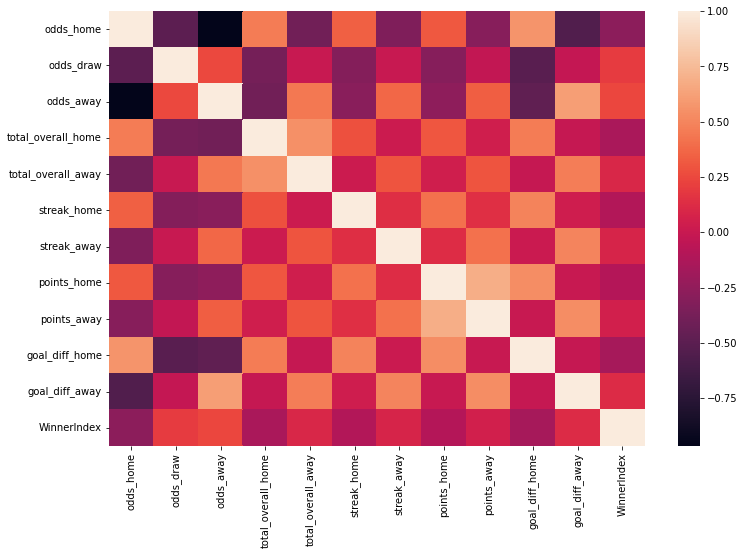

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn

# Define attributes to show in the matrix
attributes = ['odds_home', 'odds_draw', 'odds_away', 'total_overall_home', 'total_overall_away', 
              'streak_home', 'streak_away', 'points_home', 'points_away', 'goal_diff_home', 'goal_diff_away']
corrmatrix = indexed.select('odds_home', 'odds_draw', 'odds_away', 'total_overall_home', 'total_overall_away', 'streak_home', 
                       'streak_away','points_home', 'points_away', 'goal_diff_home', 'goal_diff_away', 'WinnerIndex') 
# Convert pyspark df to pandas df
corrmatrix = corrmatrix.toPandas()
# Generate the coefficients correlation matrix                            
corrmatrix = corrmatrix.corr()
# Plot an heatmap of the matrix above
fig_dims = (12, 8)
fig, ax = plt.subplots(figsize=fig_dims)
ax.set_xticklabels(['']+attributes)
ax.set_yticklabels(['']+attributes)
sn.heatmap(corrmatrix, ax=ax)
plt.show()

We decided to proceed avoiding the goal difference features because of their negative correlations with the others and with the label. The remaining features will be all assembled and scaled in the next step. They will be part of the classification features column

### **PIPELINE (ASSEMBLING AND SCALING) AND SPLITTING**

Setting the two last stages, Vector Assembling and Values Scaling, and passing them to the pipeline that goes to transform the pre-indexed dataframe.

In [ ]:
# Import of useful packages
from pyspark.ml.feature import VectorAssembler, StringIndexer
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler
import pandas

stages = []
# Assemble our selected features in a vector
assembler = VectorAssembler(inputCols = ['streak_home', 'streak_away', 'odds_home', 'odds_draw', 'odds_away', 'points_home', 'points_away', 'total_overall_home', 'total_overall_away'], outputCol='featuresVec')
# Scale values of features contained in the assembled vector
scaler = MinMaxScaler(inputCol='featuresVec', outputCol='features')
# Adding assembling and scaling stages to Pipeline stages 
stages += [assembler]
stages += [scaler]
# Instatiate the pipeline with the stages above
pipeline = Pipeline(stages = stages)
# Transform the initial dataframe
pipelineModel = pipeline.fit(indexed)
df = pipelineModel.transform(indexed)
selectedCols = ['features'] + indexed.columns
df = df.select(selectedCols)

# Split the new df in two, one for the training step and the second one for testing
train, test = df.randomSplit([0.8, 0.2])

## **BOOKMAKERS PREDICTIONS**

In this step we want to create and evaluate the performance of a personalized model based only on the odds. In this way, we will be able to compare it to the 4 choiced models trained with all the above features. This method will allow us to analyze if it is possible, through several features development, to perform better than bookkeepers models. As for every trained model in this notebook we will evaluate the following metrics: accuracy, precision, f1 and recall.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Create the prediction of the match basing on the most probable result according to the odds
test_bk_df = test.withColumn("prediction", when( (test.odds_home > test.odds_draw) & (test.odds_home > test.odds_away) , 0.0) \
                                          .otherwise(when( (test.odds_away > test.odds_home) & (test.odds_away > test.odds_draw) , 1.0) \
                                          .otherwise(2.0)))

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Compute the metrics for the auto-generated prediction based on odds (accuracy, precision, f1, recall)
accuracy_bk = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='accuracy')
print("Accuracy Test: " + str(accuracy_bk.evaluate(test_bk_df)))
precision_bk = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='precisionByLabel')
print("Precision Test: " + str(precision_bk.evaluate(test_bk_df)))
f1_bk = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='f1')
print("F1 Test: " + str(f1_bk.evaluate(test_bk_df)))
recall_bk = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='recallByLabel')
print("Recall Test: " + str(recall_bk.evaluate(test_bk_df)))

Accuracy Test: 0.5195961995249406
Precision Test: 0.551907719609583
F1 Test: 0.4392051679321626
Recall Test: 0.839262187088274


### **BOOKMAKERS PREDICTIONS - Confusion Matrix** 

In the following cell we create the confusion matrix of the above model and plot it in order to obtain a graphically feedback of the mapping between acutal and predicted values.

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Text(69.0, 0.5, 'True Values')

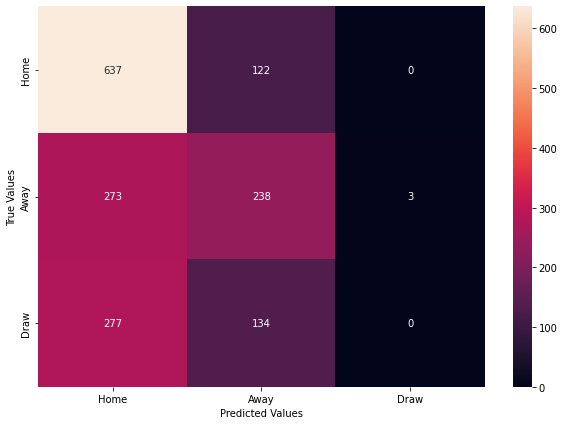

In [ ]:
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Need to cast to float type, and order by prediction
preds_and_labels_bk = test_bk_df.select(['prediction','WinnerIndex']).withColumn('label', F.col('WinnerIndex').cast(FloatType())).orderBy('prediction')

# Select only prediction and label columns
preds_and_labels_bk = preds_and_labels_bk.select(['prediction','label'])

# Evaluate multiclass classfication
metrics_bk = MulticlassMetrics(preds_and_labels_bk.rdd.map(tuple))

# Plot the heatmap containing the mapping between actual and predicted values
labels = ["Home","Away","Draw"]
df_cm_bk = pd.DataFrame(metrics_bk.confusionMatrix().toArray(), index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_bk, annot=True, fmt='g')
plt.xlabel("Predicted Values")
plt.ylabel("True Values")  

## **LOGISTIC REGRESSION**

Training, Testing an Evaluating Logistic Regression model on our computed Dataset in the Data Preparing step.

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.classification import LogisticRegression

# Instatiate the object LogisticRegression to start the classification (specifying the right name of label column)
lr = LogisticRegression(labelCol="WinnerIndex", regParam = 0.05, elasticNetParam = 0.5)
lrn = lr.fit(train)

# Make predicitons on test df
predictionsAndTarget = lrn.transform(test)

# Compute metrics for our Logistic Regression model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='accuracy')
print("Accuracy Test: " + str(accuracy_lr.evaluate(predictionsAndTarget)))
precision_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='precisionByLabel')
print("Precision Test: " + str(precision_lr.evaluate(predictionsAndTarget)))
f1_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='f1')
print("F1 Test: " + str(f1_lr.evaluate(predictionsAndTarget)))
recall_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='recallByLabel')
print("Recall Test: " + str(recall_lr.evaluate(predictionsAndTarget)))

Accuracy Test: 0.5497220506485485
Precision Test: 0.5457777777777778
F1 Test: 0.4433071321073945
Recall Test: 0.8089591567852438


In [ ]:
#import os, tempfile
#lrn.save(GDRIVE_DATA_DIR+"/LogisticRegressionModel")

In [ ]:
#lr.save(GDRIVE_DATA_DIR+"/LogisticRegression")

In [ ]:
#train.toPandas().to_csv(GDRIVE_DATA_DIR + "/TrainTestSet/train.csv")
#test.toPandas().to_csv(GDRIVE_DATA_DIR + "/TrainTestSet/test.csv")

In [ ]:
from pyspark.ml.classification import LogisticRegressionModel
model = LogisticRegressionModel.load(GDRIVE_DATA_DIR+"/LogisticRegressionModel")


In [ ]:
logreg = LogisticRegression.load(GDRIVE_DATA_DIR+"/LogisticRegression")

### **LOGISTIC REGRESSION - Cross Validation**

In this cell we define a function that help us in tuning the hyper parameters to pass to the model. In order to solve problem linked to RAM overload we've defined the function's input with a mandatory argument that is regparam. In this way we split the testing tasks and we are able to compute the function completely in different steps. 

In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np
from sklearn import metrics

def cross_validation_split(train, regparam): 
  elasticNetParamValues = [0.0, 0.5, 1.0]
  for j in elasticNetParamValues:
    print("Testing Logistic Regression with param: regParam = " + str(regparam) + ", elasticNetParam = " + str(j))
    # Testing Logistic Regression with the current elasticNetParam of the iteration and with the regParam given in input (printing the mapping between actual configuration and scores)
    lr_cv = LogisticRegression(labelCol="WinnerIndex", regParam=regparam, elasticNetParam=j)
    lrn_cv = lr_cv.fit(train)
    predictionscv = lrn_cv.transform(test)
    accuracy_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='accuracy')
    print("Accuracy Test: " + str(accuracy_lr.evaluate(predictionscv)))
    precision_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='precisionByLabel')
    print("Precision Test: " + str(precision_lr.evaluate(predictionscv)))
    f1_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='f1')
    print("F1 Test: " + str(f1_lr.evaluate(predictionscv)))
    recall_lr = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='recallByLabel')
    print("Recall Test: " + str(recall_lr.evaluate(predictionscv)))

In [ ]:
cross_validation_split(train, 0.0)

In [ ]:
cross_validation_split(train, 0.05)

In [ ]:
cross_validation_split(train, 0.1)

### **LOGISTIC REGRESSION - Confusion Matrix** 

In the following cell we create the confusion matrix of the above model and plot it in order to obtain a graphically feedback of the mapping between acutal and predicted values.

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


0.517814726840855


Text(69.0, 0.5, 'True Values')

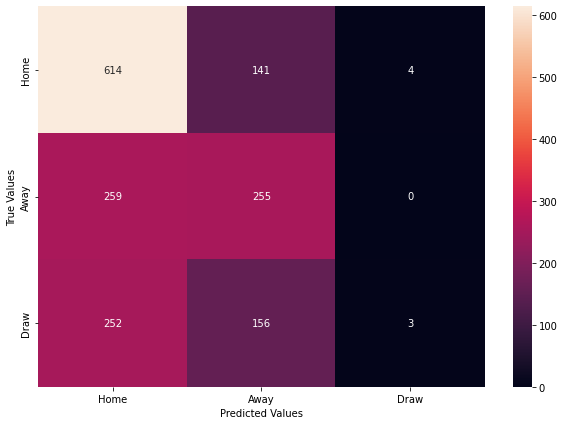

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Need to cast to float type, and order by prediction
preds_and_labels_lr = predictionsAndTarget.select(['prediction','WinnerIndex']).withColumn('label', F.col('WinnerIndex').cast(FloatType())).orderBy('prediction')

# Select only prediction and label columns
preds_and_labels_lr = preds_and_labels_lr.select(['prediction','label'])

# Evaluate multiclass classfication
metrics_lr = MulticlassMetrics(preds_and_labels_lr.rdd.map(tuple))
print(metrics_lr.accuracy)
# Plot the heatmap containing the mapping between actual and predicted values
labels = ["Home","Away","Draw"]
df_cm_lr = pd.DataFrame(metrics_lr.confusionMatrix().toArray(), index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_lr, annot=True, fmt='g')
plt.xlabel("Predicted Values")
plt.ylabel("True Values")  

## **NAIVE BAYES**

Training, Testing an Evaluating Naive Bayes model on our computed Dataset in the Data Preparing step.

In [ ]:
from pyspark.ml.classification import NaiveBayes 

# Instatiate the object NaiveBayes to start the classification (specifying the right name of label column)
nb = NaiveBayes(labelCol="WinnerIndex")
nbmodel = nb.fit(train)

# Make predicitons on test df
predictions_nb_df = nbmodel.transform(test)

# Compute metrics for our NaiveBayes model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy_nb = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='accuracy')
print("Accuracy Test: " + str(accuracy_nb.evaluate(predictions_nb_df)))
precision_nb = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='precisionByLabel')
print("Precision Test: " + str(precision_nb.evaluate(predictions_nb_df)))
f1_nb = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='f1')
print("F1 Test: " + str(f1_nb.evaluate(predictions_nb_df)))
recall_nb = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='recallByLabel')
print("Recall Test: " + str(recall_nb.evaluate(predictions_nb_df)))

Accuracy Test: 0.497624703087886
Precision Test: 0.4837662337662338
F1 Test: 0.3783899693734168
Recall Test: 0.9815546772068511


### **NAIVE BAYES - Confusion Matrix** 

In the following cell we create the confusion matrix of the above model and plot it in order to obtain a graphically feedback of the mapping between acutal and predicted values.

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Text(69.0, 0.5, 'True Values')

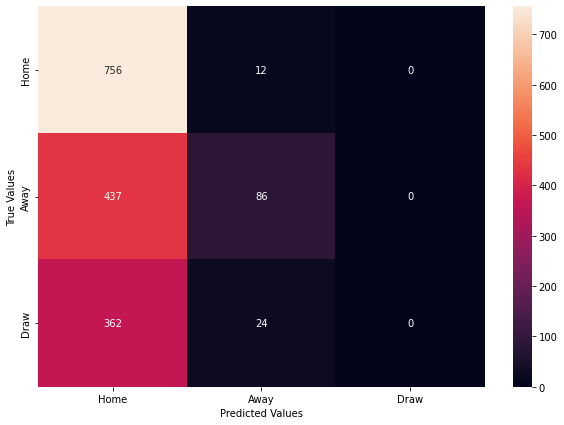

In [ ]:
import pyspark.sql.functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Need to cast to float type, and order by prediction
preds_and_labels_nb = predictions_nb_df.select(['prediction','WinnerIndex']).withColumn('label', F.col('WinnerIndex').cast(FloatType())).orderBy('prediction')

# Select only prediction and label columns
preds_and_labels_nb = preds_and_labels_nb.select(['prediction','label'])

# Evaluate multiclass classfication
metrics_nb = MulticlassMetrics(preds_and_labels_nb.rdd.map(tuple))

# Plot the heatmap containing the mapping between actual and predicted values
labels = ["Home","Away","Draw"]
df_cm_nb = pd.DataFrame(metrics_nb.confusionMatrix().toArray(), index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_nb, annot=True, fmt='g')
plt.xlabel("Predicted Values")
plt.ylabel("True Values")  

## **RANDOM FOREST**

Training, Testing an Evaluating Random Forest model on our computed Dataset in the Data Preparing step.

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

# Instatiate the object RandomForestClassifier to start the classification (specifying the right name of label column)
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'WinnerIndex')
rfModel = rf.fit(train)

# Make predicitons on test df
predictions_rf = rfModel.transform(test)

# Compute metrics for our Random Forest model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='accuracy')
print("Accuracy Test: " + str(accuracy_rf.evaluate(predictions_rf)))
precision_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='precisionByLabel')
print("Precision Test: " + str(precision_rf.evaluate(predictions_rf)))
f1_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='f1')
print("F1 Test: " + str(f1_rf.evaluate(predictions_rf)))
recall_rf = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='recallByLabel')
print("Recall Test: " + str(recall_rf.evaluate(predictions_rf)))

Accuracy Test: 0.5491043854231007
Precision Test: 0.5499565595134666
F1 Test: 0.4613316362123438
Recall Test: 0.82421875


### **RANDOM FOREST - Confusion Matrix** 

In the following cell we create the confusion matrix of the above model and plot it in order to obtain a graphically feedback of the mapping between acutal and predicted values.

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Text(69.0, 0.5, 'True Values')

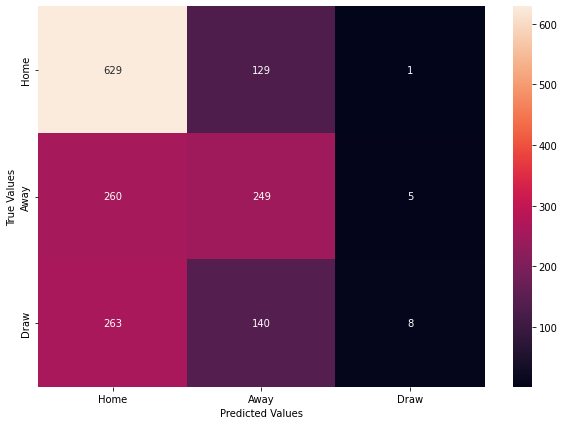

In [ ]:
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Need to cast to float type, and order by prediction
preds_and_labels_rf = predictions_rf.select(['prediction','WinnerIndex']).withColumn('label', F.col('WinnerIndex').cast(FloatType())).orderBy('prediction')

# Select only prediction and label columns
preds_and_labels_rf = preds_and_labels_rf.select(['prediction','label'])

# Evaluate multiclass classfication
metrics_rf = MulticlassMetrics(preds_and_labels_rf.rdd.map(tuple))

# Plot the heatmap containing the mapping between actual and predicted values
labels = ["Home","Away","Draw"]
df_cm_rf = pd.DataFrame(metrics_rf.confusionMatrix().toArray(), index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_rf, annot=True, fmt='g')
plt.xlabel("Predicted Values")
plt.ylabel("True Values")

##**ONE VS REST LINEAR SVC**

Training, Testing an Evaluating Support Vector Classification model with One Vs Rest technique (in order to guarantee the compatibility with a multiclass label task) on our computed Dataset in the Data Preparing step.

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Instantiate the base SV classifier.
lsvc = LinearSVC(labelCol="WinnerIndex", maxIter=10)

# Instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lsvc,labelCol="WinnerIndex")

# Train the multiclass model.
ovrModel = ovr.fit(train)

# Make predicitons on test df
predictions_svm = ovrModel.transform(test)

# Compute metrics for our SVC with OVR model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
accuracy_svm = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='accuracy')
print("Accuracy Test: " + str(accuracy_svm.evaluate(predictions_svm)))
precision_svm = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='precisionByLabel')
print("Precision Test: " + str(precision_svm.evaluate(predictions_svm)))
f1_svm = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='f1')
print("F1 Test: " + str(f1_svm.evaluate(predictions_svm)))
recall_svm = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='WinnerIndex', metricName='recallByLabel')
print("Recall Test: " + str(recall_svm.evaluate(predictions_svm)))

Accuracy Test: 0.541692402717727
Precision Test: 0.5596330275229358
F1 Test: 0.4600291944797872
Recall Test: 0.7942708333333334


### **ONE VS REST LINEAR SVC - Confusion Matrix** 

In the following cell we create the confusion matrix of the above model and plot it in order to obtain a graphically feedback of the mapping between acutal and predicted values.

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


Text(69.0, 0.5, 'True Values')

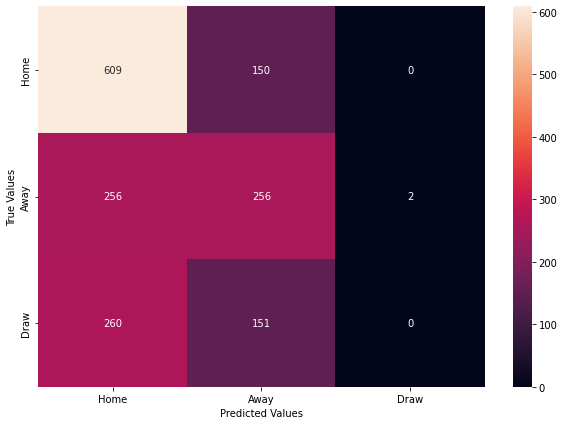

In [ ]:
import pyspark.sql.functions as F
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.types import FloatType

# Need to cast to float type, and order by prediction
preds_and_labels_svm = predictions_svm.select(['prediction','WinnerIndex']).withColumn('label', F.col('WinnerIndex').cast(FloatType())).orderBy('prediction')

# Select only prediction and label columns
preds_and_labels_svm = preds_and_labels_svm.select(['prediction','label'])

# Evaluate multiclass classfication
metrics_svm = MulticlassMetrics(preds_and_labels_svm.rdd.map(tuple))

# Plot the heatmap containing the mapping between actual and predicted values
labels = ["Home","Away","Draw"]
df_cm_svm = pd.DataFrame(metrics_svm.confusionMatrix().toArray(), index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm_svm, annot=True, fmt='g')
plt.xlabel("Predicted Values")
plt.ylabel("True Values")  

## **MODELS SUMMARIZING**

In conclusion, we can observe that the model that with our custom features perform in the better way is Logistic Regression. Whatsmore it can reach performances that are from 0 to 4 percentage points better than the ad-hoc created bookmakers model. Then the additional features can bring some benefit to models in terms of matches outcomes predictions. Surely, Logistic Regression model perform better in terms of draw prediction because of the fact that it's quite impossible that draw probabilities odds are higher than home or away. 

# **WEB APPLICATION**

In this section we're going to develop a basic web application based on:
- PySpark data manipulation
- The framework Flask to create web application routes and policies
- Ngrok in order to obtain a public temporary url for the app
- Two HTML pages to render the dataframe template and to provide the user a simple homepage to use.
The application is structured on two main pages, the Homepage where the user can select the League of its interest and then the Prediction page where a table with the list of matches with the associated home, draw, and away probabilities are shown.
In order to simplify testing and explaining phase, we've done the test on the last completed stage of season 2015/2016 of every league. The user through the dropdown select list in the Homepage can decide the league of which to see predictions of the last season/stage.

## **INSTALLING REQUIRED PACKAGES / SETTING NGROK TOKEN**

In [ ]:
!pip install flask_ngrok
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | sudo tee /etc/apt/trusted.gpg.d/ngrok.asc >/dev/null && echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list && sudo apt update && sudo apt install ngrok   
!pip install pyngrok==4.1.1
!ngrok authtoken 2ACImpDAVhaXYxMk78rhrjnxIBQ_2nJebS9m56mVwPDTUy2F

## **MAKE PREDICTIONS / DATAFRAME MANIPULATION**

In [ ]:
from pyspark.ml.classification import LogisticRegressionModel
import pyspark.sql.functions as F
#takes the most common stage in the test set
selected_stage = test.groupBy("stage").count().sort(desc("count")).select(col("stage")).collect()[0].stage
#taked the matches from the most common stage to use them in the app
test = test.filter(test.stage == selected_stage)
# Load Logistic Regression model 
model = LogisticRegressionModel.load(GDRIVE_DATA_DIR+"/LogisticRegressionModel")
# Make predictions on last complete stage of last season for every league
predictionsApp = model.transform(test)

# Team Dataframe disambiguation (we've to use it for home and away teams)
team_df_dis = team_df.alias("team_df_dis").withColumnRenamed('team_long_name', 'away_long_name')
# Get Home Team long name
test_app_home_name = predictionsApp.join(team_df, predictionsApp.home_team_api_id == team_df.team_api_id, "inner")\
                    .select(predictionsApp.match_api_id, predictionsApp.away_team_api_id, team_df.team_long_name, predictionsApp.probability,predictionsApp.prediction)\
                    .withColumnRenamed('team_long_name', 'home_team')
# Get Away Team long name
test_app_teams_name = test_app_home_name.join(team_df_dis, test_app_home_name.away_team_api_id==team_df_dis.team_api_id, "inner")\
                    .select(test_app_home_name.match_api_id, test_app_home_name.home_team, team_df_dis.away_long_name, test_app_home_name.probability, test_app_home_name.prediction)\
                    .withColumnRenamed('away_long_name', 'away_team')

# Matches Dataframe disambiguation 
match_df_dis = match_df.alias("match_df_dis").withColumnRenamed('league_id', 'league')
# Get the league and selecting final columns to show
test_app_final = test_app_teams_name.join(match_df_dis, ['match_api_id'], "inner")\
                .select(test_app_teams_name.match_api_id, test_app_teams_name.home_team, test_app_teams_name.away_team, match_df_dis.league, test_app_teams_name.probability, test_app_teams_name.prediction)

# Get from the probability vector the three probabilities for home win, away win and draw (adding them as three columns to the final df)
home = F.udf(lambda v:float(v[0]),FloatType())
away = F.udf(lambda v:float(v[1]),FloatType())
draw = F.udf(lambda v:float(v[2]),FloatType())
test_app_final = test_app_final.withColumn('Home_Probability', home('probability')*100 )
test_app_final = test_app_final.withColumn('Away_Probability', away('probability')*100 )
test_app_final = test_app_final.withColumn('Draw_Probability', draw('probability')*100 )
test_app_final = test_app_final.drop('probability')

## **FLASK APP CREATION**

In [ ]:
from flask_ngrok import run_with_ngrok
from flask import Flask, request, render_template, session, redirect
from pyspark.sql.types import FloatType, IntegerType

# Create app object and selecting folder that contains the HTML files to manage
app = Flask(__name__, template_folder='/content/gdrive/MyDrive/BigData/WebApp')

# Run app with ngrok
run_with_ngrok(app)  

# Homepage route
@app.route('/')
def index():
    return render_template('index.html')

# Homepage route
@app.route("/test" , methods=['POST'])
def test():
    # Get user league's selection
    select = request.form.get('comp_select')
    # Filtering predicted df with user's choice
    selected_df = test_app_final.filter(test_app_final.league==int(select)).drop("league","match_api_id","prediction").toPandas()
    selected_df['Home_Probability'] = selected_df['Home_Probability'].astype(float).round(decimals = 1)
    selected_df['Away_Probability'] = selected_df['Away_Probability'].astype(float).round(decimals = 1)
    selected_df['Draw_Probability'] = selected_df['Draw_Probability'].astype(float).round(decimals = 1)
    # Render the table as result on the predict page
    return render_template('predict.html', tables=[selected_df.to_html(classes='data')], titles=selected_df.columns.values)

@app.route("/bet" , methods=['POST'])
def bet():
  # Get user budget selection
  amount = int(request.form.get('amount'))
  matches_with_odds = test_app_final.join(match_df, ['match_api_id'], "inner")
  matches_with_odds = matches_with_odds.withColumn("winner", when(expr("home_team_goal-away_team_goal") > 0, 'H') \
                                          .otherwise(when(expr("home_team_goal-away_team_goal") < 0, 'A') \
                                          .otherwise('D')))
  # Take odds to evaluate gain
  matches_with_odds = matches_with_odds.select(matches_with_odds.match_api_id,
                                               matches_with_odds.prediction,
                                               matches_with_odds.B365H,
                                               matches_with_odds.B365D,
                                               matches_with_odds.B365A,
                                               matches_with_odds.winner)
  matches_with_odds.show()
  # Total budget
  investment = float(matches_with_odds.count()*amount)
  # Total gains with wins and losses
  roi = investment
  # Correct predictions and won bet
  correct_bets = 0
  # Values computation based on predictions
  for row in matches_with_odds.collect():
    if row.winner == "H":
        if row.prediction == 0.0:
          correct_bets += 1
          roi += (amount * row.B365H)-amount
        else:
          roi -= amount
    if row.winner == "A":
        if row.prediction == 1.0:
          correct_bets += 1
          roi += (amount * row.B365A)-amount
        else:
          roi -= amount
    if row.winner == "D":
        if row.prediction == 2.0:
          correct_bets += 1
          roi += (amount * row.B365D)-amount
        else:
          roi -= amount

  # Gain percentage
  net_gain = (roi-investment)/investment

  # Create Dataframe that contains and summarize values computed above  
  columns = StructType([ \
    StructField("investment",FloatType(),False), \
    StructField("roi",FloatType(), False), \
    StructField("net_gain",FloatType(), False), \
    StructField("correct_bets", IntegerType(), False), \
  ])

  computed_data = [[investment,roi,net_gain,correct_bets]]
  naive_betting = spark.createDataFrame(data = computed_data, schema = columns).toPandas()

  return render_template('bet.html', tables=[naive_betting.to_html(classes='data')], titles=naive_betting.columns.values)

# Run the Flask web app
app.run()
